# Datasets e DataLoaders no Pytorch

Demonstração do funcionamento dos Datasets e Dataloaders no Pytorch

### Objetivo

O objetivo deste notebook é demonstrar as três formas de carregar e usar dados no PyTorch:

* torch.utils.data.TensorDataset
* torch.utils.data.Dataset
* torch.utils.data.DataLoader

Neste notebook usaremos o dataset de Flores Íris, já visto anteriormente

In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset

from torchvision import transforms

from sklearn.datasets import load_iris

# Datasets

No Pytorch, datasets são objetos utilizados para armazenar, indexar, transformar e retornar elementos de um conjunto de dados.

Existem duas formas de se criar um dataset em PyTorch:

* Transformar os dados de entrada em tensores torch e criar o dataset com torch.utils.data.TensorDataset¶
* Criar uma classe filha de torch.utils.data.Dataset

## Criando um Dataset com `torch.utils.data.TensorDataset`

Se os dados e as classes forem disponibilizados em arrays do numpy ou tensores do próprio PyTorch é possível criar um dataset utilizando [torch.utils.data.TensorDataset](http://pytorch.org/docs/master/data.html#torch.utils.data.TensorDataset):

### Dados anotados: x_data (comprimento das sépalas) e target (comprimento das pétalas)  

In [2]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_data = data[:,0:1]
target = data[:,1:2]

print('dimensões de x_data:', x_data.shape)
print('dimensões de target:', target.shape)

dimensões de x_data: (50, 1)
dimensões de target: (50, 1)


### Passo 1: transformar o array numpy em tensores torch

In [3]:
x_data = torch.FloatTensor(x_data)
target = torch.FloatTensor(target)

### Passo 2: usar `TensorDataset` para criar o dataset com os tensores

In [4]:
dataset = TensorDataset(x_data, target)
len(dataset)

50

O dataset pode ser indexado como uma lista e cada elemento retorna uma tupla:
- dado de entrada e
- dado de saída.

In [5]:
i = 10
(x, y) = dataset[i]

print('sépala:', x)
print('pétala:', y)

sépala: tensor([5.])
pétala: tensor([3.5000])


## Criando um Dataset com `torch.utils.data.Dataset`

É possível criar uma nova classe personalizada representando um dataset. Esta classe deve herdar de [torch.utils.data.Dataset](http://pytorch.org/docs/master/data.html#torch.utils.data.Dataset) para tratar casos mais complexos e especiais.

### Estrutura do Dataset

Sempre que se herda de `Dataset` é preciso implementar os métodos:
- `__len__`: para retornar o tamanho do dataset, e
- `__getitem__`: para retornar um elemento de um índice dado.

O método `__len__` é chamado quando usamos a chamada `len(dataset)` do Python e `__getitem__` é chamado quando fazemos a indexação `dataset[i]`.

É possível inicializar variáveis da classe no construtor (`__init__`) do dataset.

In [6]:
from torch.utils.data import Dataset

class IrisDataset(Dataset):
    def __init__(self, x_data, target):
        super(IrisDataset, self).__init__()

        self.data = x_data
        self.target = target

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        sepala = self.data[index]
        petala = self.target[index]

        return (sepala, petala)

Nossa classe está pronta, podemos criar um objeto dela.

### Criando e testando um objeto da nossa classe

Para exemplificar o uso de classes de transformação os dados foram novamente gerados como array numpy.

In [7]:
x = data[:,0:1]
y = data[:,1:2]

dataset = IrisDataset(x, y)

Nosso método `__len__` deve retornar o tamanho da primeira dimensão dos dados.

Podemos verificar se o método está correto chamando o `len()` do Python:

In [8]:
print(len(dataset))

50


Nosso método `__getitem__()` deve retornar uma tupla na i-ésima posição no dataset, no nosso caso `data[i]` e `target[i]`:

In [9]:
i = 1
print(dataset[i])

(array([6.4]), array([4.5]))


In [10]:
data, target = dataset[30]

print('sépala:', data)
print('pétala:', target)

sépala: [5.5]
pétala: [3.8]


### Conclusão

O caso apresentado neste tópico é muito simples, apresentando os conceitos básicos da estrutura que o Pytorch utiliza para representar datasets. A classe torch.utils.data.Dataset é usada para casos complexos em que é preciso, por exemplo, carregar o dataset de arquivos e quando o gerenciamento dos dados não é tão trivial ou quando queremos aplicar uma transformação ao dado.

# DataLoaders

Um DataLoader ([torch.utils.data.DataLoader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader)) combina um Dataset e um Sampler (divide os dados em batches).

O DataLoader permite que os dados possam ser processados na forma de "mini-batches". A cada nova chamada do objeto criado com o DataLoader, um novo conjunto de dados é retornado. O DataLoader é a ferramenta do PyTorch para implementar o treinamento do gradiente descendente por "mini-batches". O treinamento por mini-batches possui duas grandes vantagens:
- Implementa o gradiente descendente estocástico via mini-batch, que acelera o treinamento;
- Permite que os dados do mini-batch a serem otimizados caibam na memória (normalmente da GPU).


## Criando um DataLoader

Vamos utilizar o dataset já criado anteriormente para ser a fonte de dados do nosso DataLoader.

In [11]:
print('tamanho do dataset: ', len(dataset))
print('amostra 12:', dataset[12])

tamanho do dataset:  50
amostra 12: (array([6.]), array([4.]))


Agora podemos criar o DataLoader com o dataset

In [12]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset,
                         batch_size=10, # tamanho do mini-batch de dados
                         shuffle=False) # se for True, embaralha os dados no inicio de cada iteração

## Iterando sobre o DataLoader

Podemos iterar sobre o DataLoader utilizando um `for`

In [13]:
batch_n = 0
n_samples = 0
for data in data_loader:
    print('batch ', batch_n)
    batch_n += 1
    n_samples += len(data[0])

print('tamanho do DataLoader', len(data_loader))
print('tamanho do dataset', n_samples)

batch  0
batch  1
batch  2
batch  3
batch  4
tamanho do DataLoader 5
tamanho do dataset 50


O tamanho do DataLoader é 5, pois temos batches de tamanho 10 dados no dataloader.

Agora podemos utilizar os dados do DataLoader:

In [14]:
batch_n = 0

for data in data_loader:
    # separa a tupla em petalas e sépalas
    data_batch, targets_batch = data

    print('dimensão do batch de sépalas {}:   {}'.format(batch_n, data_batch.size()))
    print('dimensão do batch de pétalas {}: {}\n'.format(batch_n, targets_batch.size()))
    batch_n += 1


dimensão do batch de sépalas 0:   torch.Size([10, 1])
dimensão do batch de pétalas 0: torch.Size([10, 1])

dimensão do batch de sépalas 1:   torch.Size([10, 1])
dimensão do batch de pétalas 1: torch.Size([10, 1])

dimensão do batch de sépalas 2:   torch.Size([10, 1])
dimensão do batch de pétalas 2: torch.Size([10, 1])

dimensão do batch de sépalas 3:   torch.Size([10, 1])
dimensão do batch de pétalas 3: torch.Size([10, 1])

dimensão do batch de sépalas 4:   torch.Size([10, 1])
dimensão do batch de pétalas 4: torch.Size([10, 1])



É possível ver que os batches tem mesmo 10 dados (5 matrizes 10x1 para as sépalas e 5 matrizes 10x1 para as pétalas)

No exemplo abaixo é possível ver que, com shuffle igual o False, os dados de cada mini-batch são sempre os mesmos. Cada cor contém os dados de um mini-batch:

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
data_loader = DataLoader(dataset,
                         batch_size=10, # tamanho do mini-batch de dados
                         shuffle=False) # se for True, embaralha os dados no inicio de cada iteração

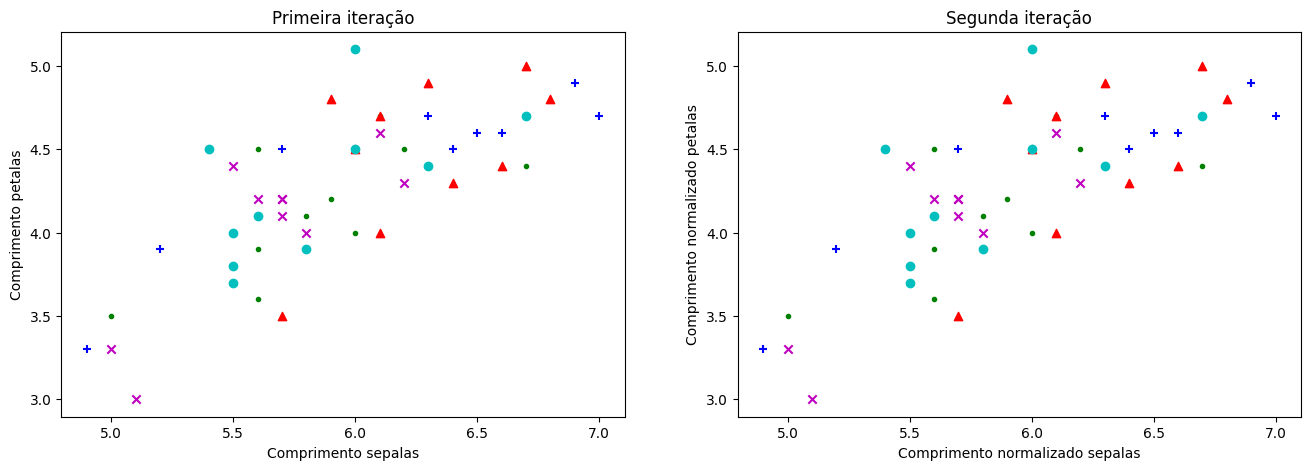

In [17]:
color = ["b","g","r","c","m"]
mark = ['+', '.', '^', 'o', 'x']
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel('Comprimento sepalas')
ax1.set_ylabel('Comprimento petalas')
ax1.set_title('Primeira iteração')

for i,data in enumerate(data_loader):
    # separa a tupla em petalas e sépalas
    data_batch, targets_batch = data

    ax1.scatter(data_batch, targets_batch, c=color[i], marker=mark[i])

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel('Comprimento normalizado sepalas')
ax2.set_ylabel('Comprimento normalizado petalas')
ax2.set_title('Segunda iteração')

for i,data in enumerate(data_loader):
    # separa a tupla em petalas e sépalas
    data_batch, targets_batch = data

    ax2.scatter(data_batch, targets_batch, c=color[i], marker=mark[i])


Com shuffle igual a True, os dados do mini-batch sempre mudam a cada iteração:

In [18]:
data_loader = DataLoader(dataset,
                         batch_size=10, # tamanho do mini-batch de dados
                         shuffle=True)  # se for True, embaralha os dados no inicio de cada iteração

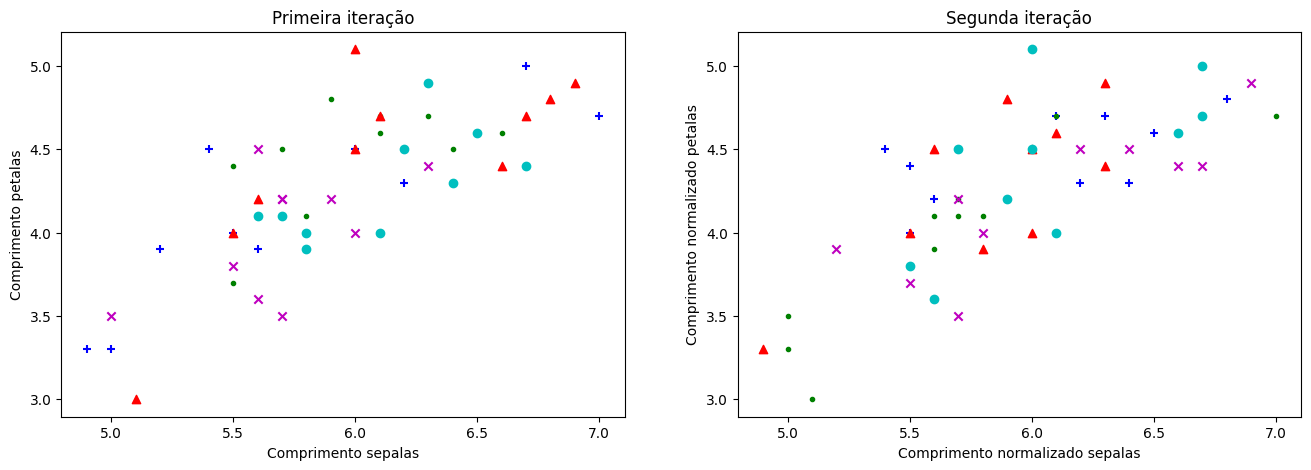

In [19]:
color = ["b","g","r","c","m"]
mark = ['+', '.', '^', 'o', 'x']
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel('Comprimento sepalas')
ax1.set_ylabel('Comprimento petalas')
ax1.set_title('Primeira iteração')

for i,data in enumerate(data_loader):
    # separa a tupla em petalas e sépalas
    data_batch, targets_batch = data

    ax1.scatter(data_batch, targets_batch, c=color[i], marker=mark[i])

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel('Comprimento normalizado sepalas')
ax2.set_ylabel('Comprimento normalizado petalas')
ax2.set_title('Segunda iteração')

for i,data in enumerate(data_loader):
    # separa a tupla em petalas e sépalas
    data_batch, targets_batch = data

    ax2.scatter(data_batch, targets_batch, c=color[i], marker=mark[i])

## Exercício

Defina seu próprio DataLoader na segunda célula abaixo. Faça com que cada batch tenha 5 elementos cada. Utilize o dataset já criado anteriormente.

Em seguida imprima o tamanho do Dataloader e tamanho do Dataset

In [21]:
# -- Defina aqui seu DataLoader com batches de 5 elementos cada ---
data_loader = DataLoader(dataset,
                         batch_size=5, # tamanho do mini-batch de dados
                         shuffle=True)  # se for True, embaralha os dados no inicio de cada iteração

# # -- tamanho do Dataloader e tamanho do Dataset

print('Tamanho do DataLoader:', len(data_loader))
print('Tamanho do Dataset:', len(dataset))



Tamanho do DataLoader: 10
Tamanho do Dataset: 50


- A ordem dos elementos se altera entre execuções da célula acima?
R: Sim, o shuffle=True faz com que, a cada nova execução ou época, o PyTorch embaralhe os dados do dataset antes de formar os mini-batches.


# Aprendizados

Aprendemos os conceitos iniciais de DataSet e DataLoader
